In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

cwd = os.getcwd()

In [4]:
img_rows, img_cols = 28, 28

data_dir = os.path.join(cwd, "..", "data")
model_dir = os.path.join(cwd, "..", "model")
LABELS = np.array(
    map(
        (lambda x : x.replace(".npy", "")),
        filter(lambda x: x.endswith('.npy'), os.listdir(data_dir))
    )
)

num_classes = len(LABELS)

In [3]:
def data_prepare():
    datas_path = filter(lambda x: x.endswith('.npy'), os.listdir(data_dir))
    dataset = np.array([]).reshape(0, img_rows * img_cols + 1)
    
    for i, d_path in enumerate(datas_path):
        data = np.load(os.path.join(data_dir, d_path))
        image_size = len(data)
        label = np.ones(image_size, dtype=int) * i
        data = np.concatenate((label[:, np.newaxis], data), axis=1)
        
        np.random.shuffle(data)

        dataset = np.append(dataset, data[0:5000], axis=0)
        print("Load {}".format(d_path))
    
    np.random.shuffle(dataset)
    dataset_len = len(dataset)
    split_x = (int)(dataset_len * 0.9)
    
    print("Dataset {} images".format(dataset_len))
    print("Train {} images".format(split_x))
    print("Test {} images".format(dataset_len - split_x))
    
    print("Write data to pickle files...")
    
    pickle.dump(dataset[0:split_x], open(os.path.join(data_dir, "train.pickle"), "wb"))
    pickle.dump(dataset[split_x:-1], open(os.path.join(data_dir, "test.pickle"), "wb"))
    
    print("Finish")

if not os.path.exists(os.path.join(data_dir, "train.pickle")):
    print("Prepare pickle data")
    data_prepare()

In [15]:
x_train = None
y_train = None
x_test = None
y_test = None

def load_dataset():
    global x_train, y_train, x_test, y_test
    train_data = pickle.load(open(os.path.join(data_dir, "train.pickle"), "rb"))
    test_data = pickle.load(open(os.path.join(data_dir, "test.pickle"), "rb"))
    x_train = train_data[:,1:]
    y_train = train_data[:,0]
    x_test = test_data[:,1:]
    y_test = test_data[:,0]
    print("Load dataset complete")

load_dataset()

Load dataset complete


In [ ]:
for i in range(10):
    plt.imshow(x_train[i].reshape(28,28))
    plt.title(LABELS[(int)(y_train[i])])
    plt.show()

### Data Prepossing

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

Using TensorFlow backend.


In [16]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

y_train_onehot = keras.utils.to_categorical(y_train, num_classes)
y_test_onehot = keras.utils.to_categorical(y_test, num_classes)

print(x_train.shape)
print(y_train_onehot.shape)
print(x_test.shape)
print(y_test_onehot.shape)

(45000, 28, 28, 1)
(45000, 10)
(4999, 28, 28, 1)
(4999, 10)


### Model

In [20]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(img_rows, img_cols, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adadelta(),
    metrics=['accuracy']
)

model.fit(
    x_train, y_train_onehot,
    batch_size = 32,
    epochs = 3,
    verbose = 1
)

model.save(os.path.join(model_dir, 'model.h5'))

Epoch 1/3
45000/45000 [==============================] - 349s - loss: 0.6901 - acc: 0.7894   
Epoch 2/3
45000/45000 [==============================] - 329s - loss: 0.3673 - acc: 0.8942   
Epoch 3/3
45000/45000 [==============================] - 364s - loss: 0.3185 - acc: 0.9070   


In [17]:
model = keras.models.load_model(os.path.join(model_dir, 'model-1.h5'))

score = model.evaluate(x_test, y_test_onehot, verbose = 1)
print("\nAccuracy {}".format(score[1]))

4992/4999 [============================>.] - ETA: 0s
Accuracy 0.920384076815


[[404   0  16   5   1  12   1   1  28   4]
 [  2 438   2   2   1  12   0   3   8   5]
 [ 15   1 478   0   2   0   0   0   9   0]
 [  4   2   5 456   2  13   3   5   9   9]
 [ 12   6   6   3 418  11   1  12  20   5]
 [  4   1   0   5   0 457   1   6   7  12]
 [  5   1   1   5   0   8 513   1   5   1]
 [  1   1   0   3   2   7   0 473   1   1]
 [ 16   1   5   0   0   3   2   0 476   2]
 [  4   1   0   8   0  10   0   5   4 488]]


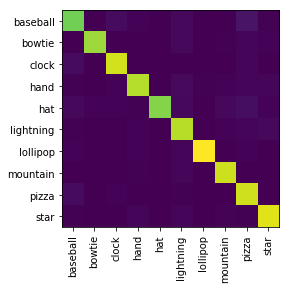

In [32]:
from sklearn.metrics import confusion_matrix

# y_pred = np.argmax(model.predict(x_test, verbose=1), axis=1)
confusion_matrix = confusion_matrix(y_test.astype(int), y_pred)

print(confusion_matrix)

plt.imshow(confusion_matrix, interpolation='nearest')
plt.xticks(np.arange(0,num_classes), LABELS, rotation=90)
plt.yticks(np.arange(0,num_classes), LABELS)

plt.show()